In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import sys, os

In [3]:
sys.path.append(os.path.abspath('../olo-with-side-information'))

In [4]:
import datasets

We will define four functions corresponding to four different algorithms for OCO. In each of these, $\texttt{Features}$ is taken to be a $T \times d$ matrix with each row corresponding to ${\bf x}_t$ and $\texttt{Responses}$ is a $d-$dimensional array with $t-$th entry corresponding to $y_t$. 

First we implement OGD as a function and record the total loss. Please refer to the notes for the theoretical component. 

In [5]:
def OGD(U, Features, Responses):      #U is a learning rate parameter---we use eta_t = U/sqrt{t}

    T,d = Features.shape

    Loss_OGD = 0 #This variable stores the cumulative loss
    Loss_OGD_linearized = 0 #This variable stores \sum <g_t, w_t>
    w_t = np.zeros(d) #Initializing w to zero vector 

    for time in range(T):   #Remember t = 0.....T-1 as python default 

        #Reveal x_t and y_t
        x_t = Features[time] #Already normalized so that ||x_t|| = 1 
        y_t = Responses[time] #A real number

        #Play vector w_t and incur  loss l_t(w_t) = |<w_t,x_t> - y_t|
        Loss_OGD = Loss_OGD + abs(np.inner(w_t, x_t) - y_t)

        #We will now update w_t using gradient descent, so first lets calcuate gradient of l_t at w_t
        if np.inner(w_t, x_t) < y_t:
            g_t = -x_t 
        else :
            g_t = x_t #this subsumes the case when <x_t,w_t> = y_t
        Loss_OGD_linearized = Loss_OGD_linearized + np.inner(g_t, w_t)

        #Perform gradient descent step 
        eta_t = U/((time+1)**0.5) #Setting the learning rate, recall the python numbering, thats why we have t+1 
        w_t = w_t - eta_t*g_t    #No need for projection since w_t is unrestricted 
    return Loss_OGD  #, Loss_OGD_linearized 

Now, we implement the parameter-free DFEG method of Orabona. We need to tweak the OGD method a bit. Please refer to notes for theoretical detail.

In [6]:
#DFEG
def DFEG(Features, Responses, a = 1, delta = 1, L = 1):

    T,d = Features.shape

    #initializing variables
    theta_t = np.zeros(d)
    H_t = delta 
    Loss_DFEG = 0
    Loss_DFEG_linearized = 0

    for time in range(T):   
        
        #Recieve x_t
        x_t = Features[time] #A d-dimensional array already normalized so ||x_t|| = 1
    
        #Prepare a w_t
        H_t = H_t + L**2 #Since x_t is normalized and ||x_t|| = 1
        alpha_t = a*(H_t**0.5)
        beta_t = H_t**1.5

        if np.linalg.norm(theta_t) == 0:
            w_t = np.zeros(d)
        else :
            NormTh = np.linalg.norm(theta_t)
            w_t = theta_t*(np.exp(NormTh/alpha_t)/(beta_t*NormTh)) #The exponentiated gradient step

        #Recieve y_t and therefore the loss function l_t 
        y_t = Responses[time]
        
        #Play w_t and incur loss
        Loss_DFEG = Loss_DFEG + abs(np.inner(w_t, x_t) - y_t)   

        #Now to update theta_t we will need the gradient of l_t(y) = |y - y_t| at y = <x_t,w_t>
        if np.inner(w_t, x_t) < y_t:
            SubGradient_t = -1    #Setting the subgradient 
        else :
            SubGradient_t = 1       #this subsumes the case when <x_t,w_t> = y_t
        g_t = x_t*SubGradient_t       #Subgradient of the function l_t(w) = |<w,x_t> - y_t| at w = w_t
        Loss_DFEG_linearized = Loss_DFEG_linearized + np.inner(g_t, w_t)
        
        #Now update the theta
        theta_t = theta_t - x_t*SubGradient_t
    return Loss_DFEG #, Loss_DFEG_linearized


Next, we will implement McMahan and Orabona's AdaptiveNormal.

In [7]:
def AdaptiveNormal(Features,Responses, a = 10, L = 1, eps = 1):

    #AdaptiveNormal 
    T,d = Features.shape

    #Initialize the variables
    Loss_adanorm = 0 #This variable stores the cumulative loss
    Loss_adanorm_linearized = 0 
    theta_t = np.zeros(d)  

    for time in range(T):  
        
       #Set the w_t
        if np.linalg.norm(theta_t) == 0:
            w_t = np.zeros(d)
        else :
            NormTh = np.linalg.norm(theta_t)
            Term1 = np.exp(((NormTh+L)**2)/(2*a*(time+2))) - np.exp(((NormTh-L)**2)/(2*a*(time+2)))
            Term2 = (2*L*(np.log(time+3))**2)**(-1)
            w_t = theta_t*eps*Term1*Term2/NormTh #AdaptiveNormal step

       #Load x_t and y_t
        x_t = Features[time] #Normalized to ||x_t|| = 1
        y_t = Responses[time] 
        
       #Receive g_t, which is subgradient of l_t(w) = |<w,x_t> - y_t| at w=w_t
        if np.inner(w_t, x_t) < y_t:
            g_t = -x_t 
        else :
            g_t = x_t

        #suffer the losses 
        Loss_adanorm = Loss_adanorm + abs(np.inner(w_t, x_t) - y_t) 
        Loss_adanorm_linearized = Loss_adanorm_linearized + np.inner(g_t, w_t)

        #Now update theta_t, recall that theta_t keeps track of \sum_{i=1}^{time} -g_t
        theta_t = theta_t - g_t
    return Loss_adanorm

Now we will implement the coin-betting based KT algorithm. Again, we will use the standard conversion of OCO to OLO by gradients $g_t$.

In [8]:
def KTBetting(Features, Responses, eps = 100):

    T,d = Features.shape

    #Initialize variables
    w_t = np.zeros(d)
    Loss_KT = 0
    Losses_sum = 0 #Will keep track of \sum_{i=1}^{t-1} <w_t, g_t>  
    Gradients_sum = np.zeros(d)  #Will keep track of \sum_{i=1}^{t-1} g_t   

    for time in range(T):

        #Play w_t
        w_t = (Losses_sum + eps)/(time+1)*Gradients_sum

        #Load x_t and y_t
        x_t = Features[time] 
        y_t = Responses[time] 

        #Incur loss 
        Loss_KT = Loss_KT + abs(np.inner(w_t, x_t) - y_t) 

        #Calculate g_t  (changing signs from before since this is reward scenario)
        if np.inner(w_t, x_t) < y_t:
            g_t = x_t #Setting the subgradient 
        else :
            g_t = -x_t #this subsumes the case when <x_t,w_t> = y_t

        #Update the variables 
        Losses_sum = Losses_sum + np.inner(g_t, w_t) # = \sum_{i = 1}^{time+1} <g_t, w_t>
        Gradients_sum = Gradients_sum + g_t # = \sum_{i = 1}^{time+1} g_t
    
    Loss_KT_linearized = Losses_sum #since this is already keeping track of \sum <g_t,w_t>
    return Loss_KT   #, Loss_KT_linearized 

We will now try on the real datasets.

In [9]:
data = datasets.YearPredictionMSD(standardize=False, normalize=True)  # default preprocessing used in (Orabona and Pal, 2016)
Features = data.X  # attributes (data size, dimensions) 
Responses = data.y  # target variables (data size,)

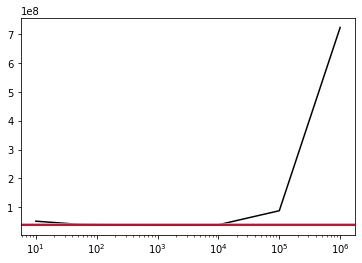

In [10]:
U_vec = np.array([10, 50, 100, 200, 500, 1000, 2000, 10**4, 10**5, 10**6])

OGDErrors = np.zeros(len(U_vec))
for i in range(len(U_vec)):
    U = U_vec[i]
    OGDErrors[i] = OGD(U, Features, Responses)

DFEGError = DFEG(Features,Responses)
AdaNormError = AdaptiveNormal(Features,Responses)
KTError = KTBetting(Features,Responses)

plt.semilogx(U_vec, OGDErrors, color='k')
plt.axhline(DFEGError, color='y', linestyle='-')
plt.axhline(AdaNormError, color='b', linestyle='-')
plt.axhline(KTError, color='r', linestyle='-')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

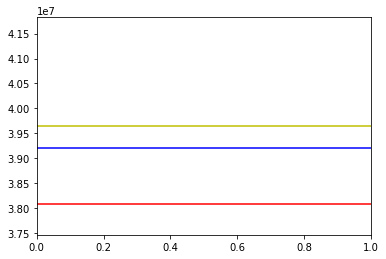

In [12]:
plt.axhline(DFEGError, color='y', linestyle='-')
plt.axhline(AdaNormError, color='b', linestyle='-')
plt.axhline(KTError, color='r', linestyle='-')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()